In [56]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
import pandas as pd 
import time

In [164]:
sess = tf.InteractiveSession()

In [54]:
def current_milli_time() -> int: return int(round(time.time() * 1000))

In [3]:
my_words = list(open("test-my-word-2-vec.txt",encoding="UTF-8").read())
my_words = pd.Series(my_words)

In [4]:
count = my_words.value_counts().sort_values(ascending=False)
chars  = count.index.sort_values()
char_ids = pd.DataFrame(list(zip(chars,list(range(len(chars))))),columns=["char","id"])

dictionary = char_ids.set_index("char")["id"].to_dict()
dictionary_reverse = char_ids.set_index("id")["char"].to_dict()

In [100]:
df = pd.read_csv("./test-my-word-2-vec.csv",encoding="UTF-8")
df["feature"] = df.feature.map(dictionary)
df["label"] = df.label.map(dictionary)
len(df)

5442

In [131]:
def get_batch(df, batch_size, iter_number):
    start = int(iter_number * batch_size)
    end = int((iter_number + 1) * batch_size)
    df_size = len(df)
    index = map(lambda i: i % len(df), range(start, end))
    return df.loc[list(index)]
get_batch(df,10,10)

,feature,label
100,50,46
101,50,511
102,511,50
103,511,532
104,532,511
105,532,589
106,589,532
107,589,682
108,682,589
109,682,568


In [158]:
skip_window = 1
batch_size = 32
embedding_size = 32
num_sampled = 64
LEARNING_RATE = 0.001
max_iter_steps = 10000 +  1
NUM_SAMPLED = 64
vocabulary_size = len(chars)
vocabulary_size

684

In [165]:
center_words = tf.placeholder(tf.int32,shape=[batch_size],name="center_words")
targer_words = tf.placeholder(tf.int32,shape=[batch_size,1],name="target_words")
embed_matrix = tf.Variable(tf.random_uniform([vocabulary_size,embedding_size],-1.0,1),name="embed_matrix")
embed = tf.nn.embedding_lookup(embed_matrix,center_words,name="embed")

nce_weight = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                                    stddev=1.0 / (embedding_size ** 0.5)), 
                                                    name='nce_weight')
nce_bias = tf.Variable(tf.zeros([vocabulary_size]), name='nce_bias')
loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weight, 
                                            biases=nce_bias, 
                                            labels=targer_words, 
                                            inputs=embed, 
                                            num_sampled=NUM_SAMPLED, 
                                            num_classes=vocabulary_size), name='loss')
optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)

norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm

with sess.as_default() as sess:
    sess.run(tf.global_variables_initializer())
    total_loss = 0.0 
    writer = tf.summary.FileWriter('./graphs/no_frills/', sess.graph)
    for i in range(max_iter_steps):
        batch= get_batch(df,batch_size=batch_size,iter_number=i)
        batch_data = batch["feature"].values
        batch_labels = batch["label"].values.reshape([batch_size,1])
        the_loss,_ = sess.run([loss,optimizer],feed_dict={center_words:batch_data,targer_words:batch_labels})
        total_loss += the_loss
        if (i % 1000 ==0):
            print('Average loss at step {}: {:5.1f}'.format(i, total_loss / 1000))
            total_loss = 0.0
    writer.close()


Average loss at step 0:   0.1
Average loss at step 1000:  99.2
Average loss at step 2000:  33.7
Average loss at step 3000:  12.9
Average loss at step 4000:   7.2
Average loss at step 5000:   5.1
Average loss at step 6000:   4.2
Average loss at step 7000:   3.8
Average loss at step 8000:   3.4
Average loss at step 9000:   3.1
Average loss at step 10000:   2.9


In [214]:
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))

valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

sim = similarity.eval()
sim_df = pd.DataFrame(sim)
sim_df.index = valid_examples
for i in sim_df.index:
    near = sim_df.loc[i].sort_values(ascending=False).head(10).index
    near = pd.Series(near)
    near = near.map(dictionary_reverse).values
    print("%s - near:%s" %(dictionary_reverse[i],near))

于 - near:['于' '。' '喷' '“' '洞' '那' 'P' '急' '是' '难']
下 - near:['下' '呼' '词' '。' '陆' '折' '银' '囚' '方' '糊']
E - near:['E' '骨' '（' '词' '表' '字' '务' '空' '产' '苏']
c - near:['c' '诸' '务' '彼' '媒' '2' '线' '服' '授' '见']
• - near:['•' '生' '为' '瞬' '味' '应' 'M' '另' '交' '两']
三 - near:['三' '努' '枪' '装' 'R' '争' '委' '夜' '分' '公']
1 - near:['1' 'C' '炮' '宫' '直' 'L' '广' '巧' '甚' '怎']
他 - near:['他' '喷' '个' '诸' '力' '地' '们' '即' '右' '委']
《 - near:['《' '架' '园' '目' '乎' '名' '晨' '些' '其' '叫']
i - near:['i' '么' '凭' '聘' '然' '轻' '尔' '劫' '长' '诉']
N - near:['N' '挥' '战' '括' '片' '图' '授' '带' '喷' '属']
G - near:['G' '构' 'F' '战' '易' '宫' '房' '示' '年' '伦']
五 - near:['五' '受' '些' '咙' '运' '科' '折' '束' '有' '许']
b - near:['b' '同' '2' 'n' '经' '米' '在' '俯' '频' '挥']
- - near:['-' '最' '护' '散' '穿' '表' '蔡' '先' '果' '备']
事 - near:['事' '血' '实' '定' '切' '跳' '重' '记' '说' '把']


In [215]:
# dictionary_reverse

In [61]:
train_features = tf.placeholder(tf.int32, shape=[batch_size],name="train_featuers")
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1],name="train_labels")
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],stddev=1.0 / math.sqrt(embedding_size)))
softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
embed = tf.nn.embedding_lookup(embeddings, train_features)
loss = tf.reduce_mean(
  tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                             labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [133]:
num_steps = 1000
with tf.Session() as session : 
    tf.global_variables_initializer().run()
    session.run(feature_iterator.initializer)
    session.run(label_iterator.initializer)
    average_loss=0
    for step in range(num_steps):
        batch = get_batch(df,batch_size=batch_size,iter_number=step)
        batch_data = batch["feature"].values
        batch_labels = batch["label"].values
        feed_dict = {train_features : batch_data, train_labels : batch_labels.reshape([batch_size,1])}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 100 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = dictionary_reverse[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = dictionary_reverse[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Average loss at step 0: 3.542005
Nearest to 8: 场, 设, 焦, 轮, 宫, 做, 我, @,
Nearest to 乎: 吧, 炮, 轮, 进, 种, 园, 跳, 忙,
Nearest to 《: 图, 极, 悉, 廊, 正, 告, 击, 望,
Nearest to i: 部, 挥, 伦, 总, 炸, 内, 权, 不,
Nearest to 习: d, 帮, 把, l, 边, 经, 迫, 咙,
Nearest to 》: 明, 系, 园, 萨, 骑, 故, 提, 补,
Nearest to L: 广, 倒, g, 举, 喷, 女, •, 
,
Nearest to 于: 管, 件, 确, -, 海, 9, 怎, 卷,
Nearest to 不: 炸, ）, 过, i, 定, 展, 习, 挥,
Nearest to -: 示, 脱, 改, 士, 广, 于, 焦, 罩,
Nearest to b: o, 伯, 世, 查, 他, 发, 立, 特,
Nearest to 件: 间, 确, 树, 于, 少, 一, 爆, 考,
Nearest to n: 便, 壳, 树, 般, 纪, 年, 告, 药,
Nearest to 么: ’, P, 争, 枪, 疗, G, 拿, 许,
Nearest to 个: “, 半, 塞, 秒, 兴, 树,  , 概,
Nearest to 下: 2, 膛, 吧, 方, 列, 黏, 骂, 诉,
Average loss at step 100: 0.170642
Average loss at step 200: 0.155209
Average loss at step 300: 0.120333
Average loss at step 400: 0.116734
Average loss at step 500: 0.102568
Average loss at step 600: 0.093720
Average loss at step 700: 0.092693
Average loss at step 800: 0.077418
Average loss at step 900: 0.078746


In [168]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

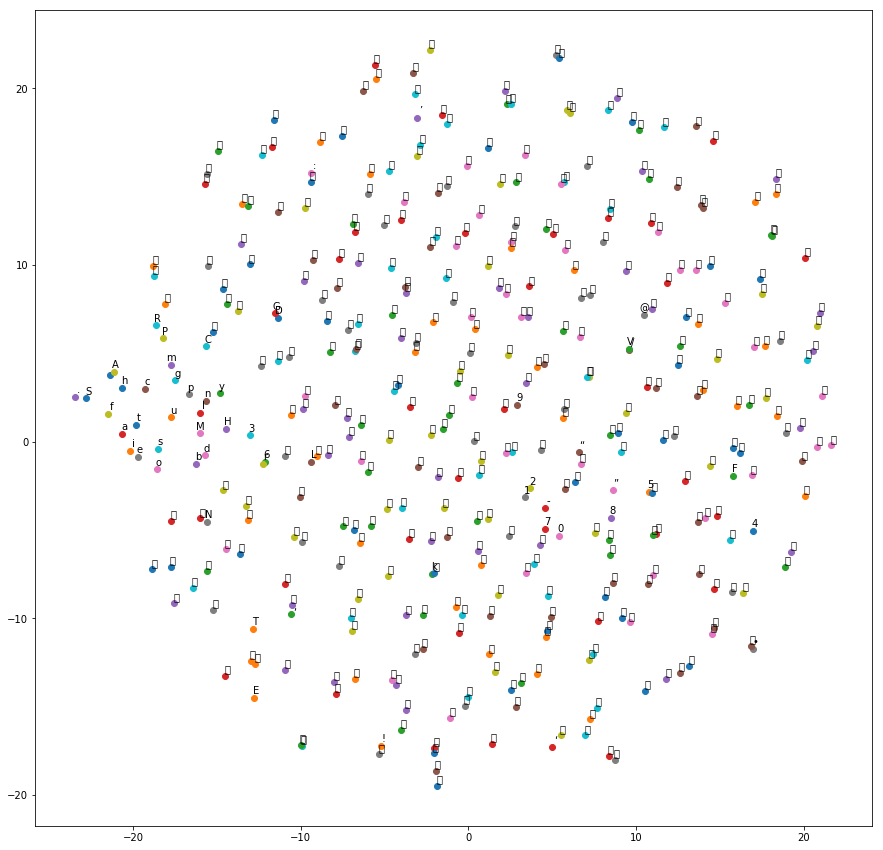

In [169]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [dictionary_reverse[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In [ ]:
# data[0:2]
# data[0:1]
# data[1:2]
# pd.DataFrame({
#     "feature": result_feature,
#     "lable" : result_lable
# })